# Solving the SWE using NN + FNO

In [33]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, SimpleRNN, BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import torch
import torch.nn as nn


## Load data

In [34]:
# Load a single .mat file
filename = 'dataFNO/data_sigma_no1.mat'
mat_data = scipy.io.loadmat(filename)

# Print the keys of the loaded data
print(mat_data.keys())

# Extract the necessary data (x and h_all) from the loaded data
x = mat_data['x'].flatten()
h_all = mat_data['h_all'][1:,:]
t = mat_data['time_all'].flatten()

h_all.shape
sigma = mat_data['sigma'][0,0]

print('sigma:', sigma)


dict_keys(['__header__', '__version__', '__globals__', 'h0', 'h_all', 'sigma', 'time_all', 'u_all', 'x'])
sigma: 0.1


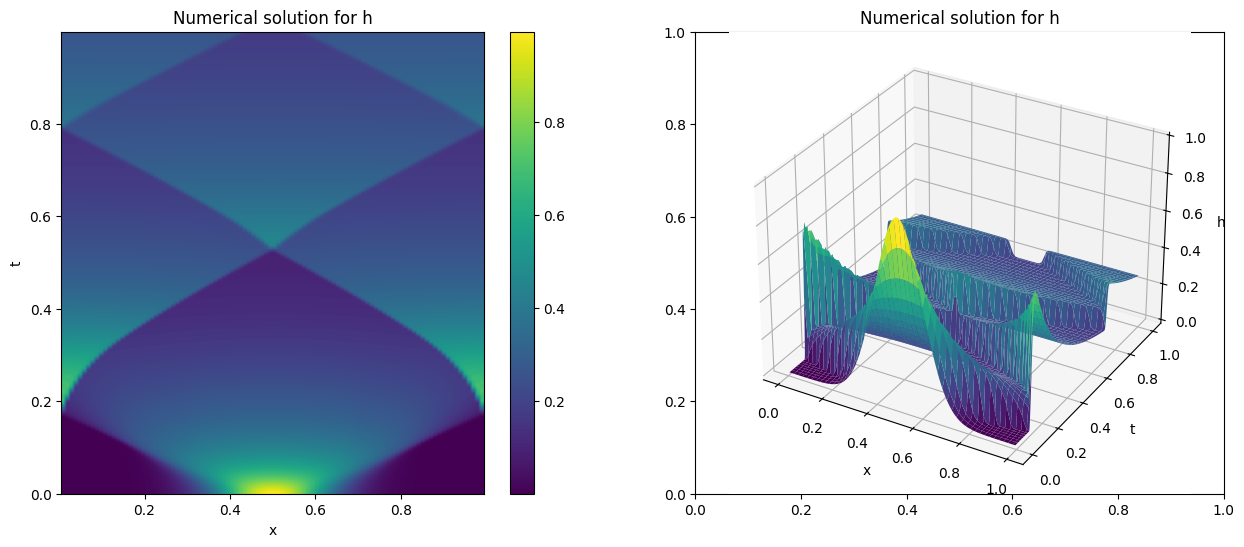

In [35]:
save = 1

# Plot the data in x,t space
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
img = ax[0].imshow(h_all, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution for h')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x, t)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, h_all, cmap='viridis')
ax[1].set_title('Numerical solution for h')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('h')

if save:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()


In [36]:
# Define percentage of data to use for training
P = 0.8

# Split the data into training and testing sets
n_train = int(P * len(t))

h_train = h_all[:n_train, :]
h_test = h_all[n_train:, :]

# Split X and T into training and testing sets
X_train = X[:n_train, :]
X_test = X[n_train:, :]
T_train = T[:n_train, :]
T_test = T[n_train:, :]

## Solve the SWE using NN

### (i) FNN

Epoch 1/300


c:\Users\Matteo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8745 - val_loss: 0.0687
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0597 - val_loss: 0.0731
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0467 - val_loss: 0.0175
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - val_loss: 0.0289
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - val_loss: 0.0261
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - val_loss: 0.0065
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0126 - val_loss: 0.0631
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0182
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - val_loss: 0.0079
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - val_loss: 0.0075
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - val_loss: 0.0047
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_l

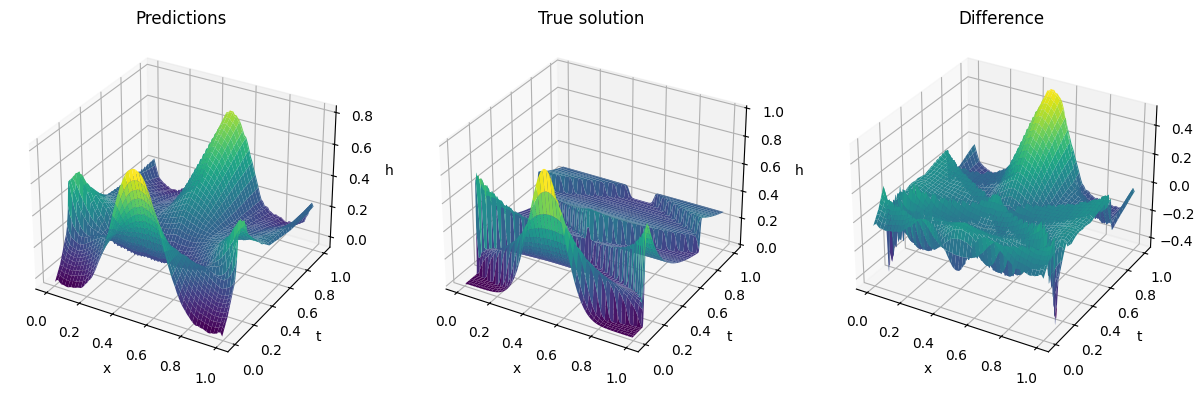

In [37]:
X, T = np.meshgrid(x, t)

# Define the NN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X.shape[1] + T.shape[1],)))
model.add(BatchNormalization())  # Batch normalization layer
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(64, activation='relu'))
model.add(Dense(h_all.shape[1])) # Output layer

# Compile the model
learning_rate = 0.01 # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(np.hstack([X_train, T_train]), h_train, epochs=300, batch_size=16, validation_split=0.2)

# Evaluate the model on the test data
loss = model.evaluate(np.hstack([X_test, T_test]), h_test)
print(f'Test loss: {loss}')

# Make predictions on the testing data
predictions = model.predict(np.hstack((X, T)))

# Plot the predictions
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, T, predictions, cmap='viridis')
ax.set_title('Predictions')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X, T, h_all, cmap='viridis')
ax.set_title('True solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X, T, predictions - h_all, cmap='viridis')
ax.set_title('Difference')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

if save:
    plt.savefig('plots/NN_predictions.pdf', format='pdf')

plt.show()

plt.show()


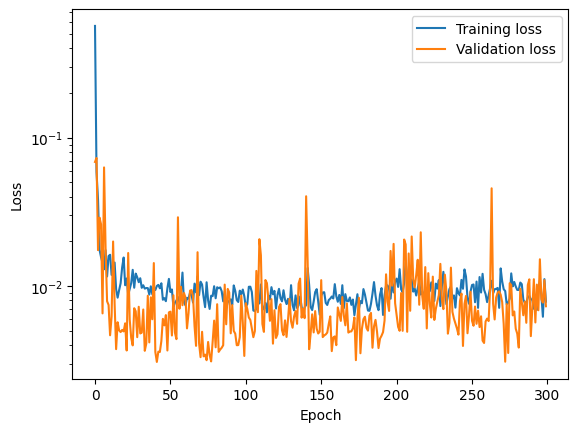

In [38]:
# Plot the training and validation loss
plt.semilogy(history.history['loss'], label='Training loss')
plt.semilogy(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

if save:
    plt.savefig('plots/NN_loss_train_val.pdf', format='pdf')

plt.show()

plt.show()

#### Calculate error in the different time steps

RMSE: 0.10578711038593613


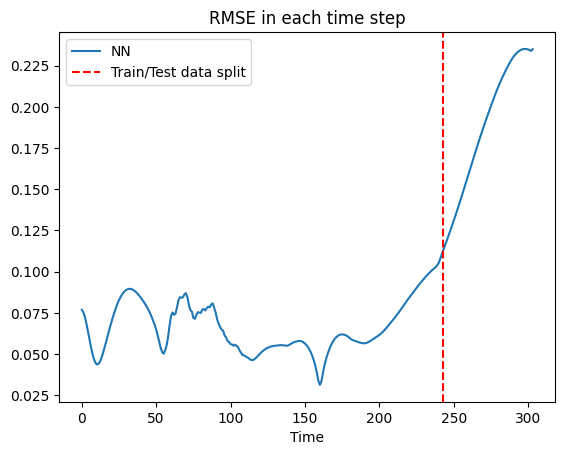

In [39]:
# Calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for the predictions
rmse_val = rmse(predictions, h_all)
print(f'RMSE: {rmse_val}')

# Plot error
error_NN = []

for i in range(h_all.shape[0]):
    error_NN.append(rmse(predictions[i], h_all[i]))

plt.plot(error_NN, label='NN')
plt.axvline(x=n_train, color='r', linestyle='--', label='Train/Test data split')
plt.xlabel('Time')
plt.title('RMSE in each time step')
plt.legend()
plt.show()


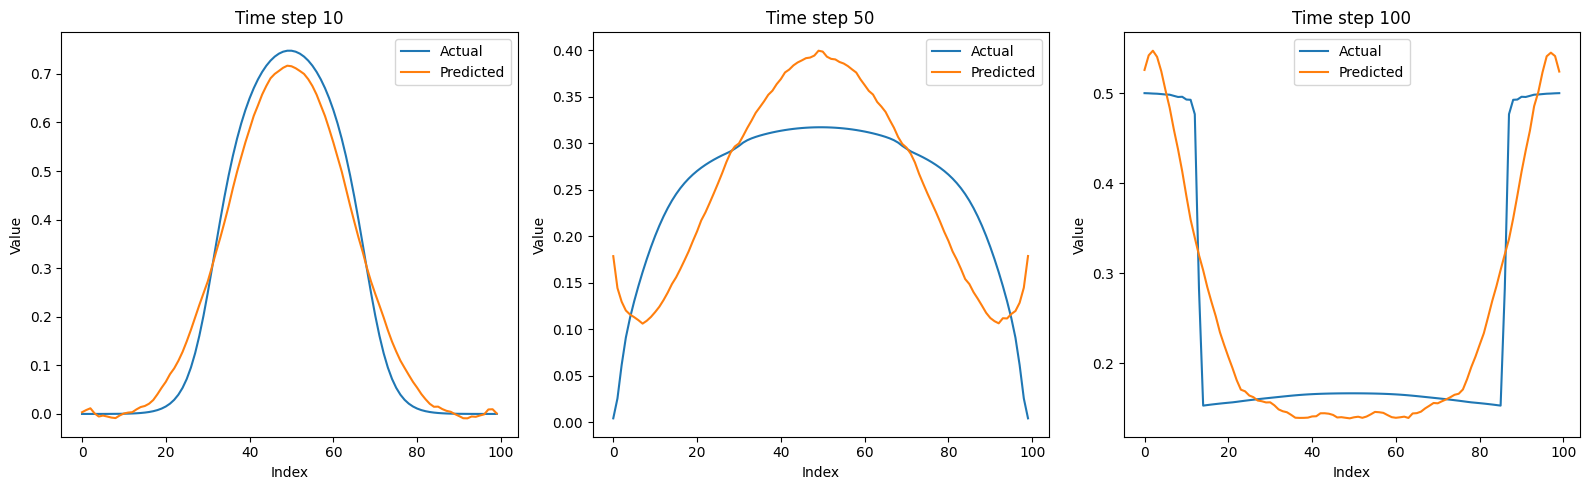

In [40]:
# Define the indices for the plots
indices = [10, 50, 100]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

# Plot for each index
for i, index in enumerate(indices):
    ax = axes[i]
    ax.plot(h_all[index], label='Actual')
    ax.plot(predictions[index], label='Predicted')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Time step {index}')

if save:
    plt.savefig("plots/NN_predictions_time_steps.pdf", format="pdf")

plt.tight_layout()
plt.show()

### (ii) LSTM

In [41]:
if 0:    
    X, T = np.meshgrid(x, t)

    # Define the RNN model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1] + T.shape[1], 1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(h_all.shape[1])) # Output layer

    # Compile the model
    learning_rate = 0.001 # Adjust this value as needed
    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = model.fit(np.hstack([X_train, T_train]), h_train, epochs=100, batch_size=16, validation_split=0.2)

    # Evaluate the model on the test data
    loss = model.evaluate(np.hstack([X_test, T_test]), h_test)

    # Make predictions on the testing data
    predictions = model.predict(np.hstack((X, T)))

    # Plot the predictions
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(X, T, predictions, cmap='viridis')
    ax.set_title('Predictions')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('h')

    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(X, T, h_all, cmap='viridis')
    ax.set_title('True solution')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('h')

    ax = fig.add_subplot(133, projection='3d')
    ax.plot_surface(X, T, predictions - h_all, cmap='viridis')
    ax.set_title('Difference')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('h')

    plt.show()

In [42]:
if 0:
    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [43]:
if 0:
    # Calculate RMSE
    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

    # Calculate the RMSE for the predictions
    rmse_val = rmse(predictions, h_all)
    print(f'RMSE: {rmse_val}')

    # Plot error
    error_NN = []

    for i in range(h_all.shape[0]):
        error_NN.append(rmse(predictions[i], h_all[i]))

    plt.plot(error_NN, label='NN')
    plt.axvline(x=n_train, color='r', linestyle='--', label='Train/Test data split')
    plt.xlabel('Time')
    plt.title('RMSE in each time step')
    plt.legend()
    plt.show()


In [44]:
if 0:   
    # Define the indices for the plots
    indices = [100, 150, 300]

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

    # Plot for each index
    for i, index in enumerate(indices):
        ax = axes[i]
        ax.plot(h_all[index], label='Actual')
        ax.plot(predictions[index], label='Predicted')
        ax.legend()
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.set_title(f'Time step {index}')

    # Save the figure
    plt.tight_layout()
    plt.show()

## Solve the SWE using FNO

In [45]:
save = 0

### Define network

In [46]:
class SpectralConv2d(nn.Module):
    def __init__(self,
                 in_channels,   # Number of input channels
                 out_channels,  # Number of output channels
                 modes1,        # Number of Fourier modes to multiply in the first dimension
                 modes2):       # Number of Fourier modes to multiply in the second dimension
        super(SpectralConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]

        # Add an extra dimension to the end of the tensor
        if x.dim() == 3:
            x = x.unsqueeze(-2)

        #Compute Fourier coeffcients
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

        # Remove the extra dimension
        if x.shape[-2] == 1:
            x = x.squeeze(-2)

        return x

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

In [47]:
# Get dimensions
N1, N2 = h_all.shape
print(N1, N2)

# Prepare data
h_tensor = torch.tensor(h_all, dtype=torch.float32).unsqueeze(1) # Target tensor
h_tensor = h_tensor.unsqueeze(-1)
print(h_tensor.shape)

304 100
torch.Size([304, 1, 100, 1])


### Define model

In [48]:
# Define the model
model = SpectralConv2d(2, 1, 100, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criteria = nn.MSELoss()

losses = []

n_epochs = 3000
for epoch in range(n_epochs):

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    output = model(h_tensor) # Predict
    loss = criteria(output, h_tensor) # Calculate loss
    losses.append(loss.item()) # Save loss

    # Backward pass
    loss.backward() # Calculate gradients
    optimizer.step() # Update weights

    # Print loss
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

y_pred = model(h_tensor).detach().numpy().squeeze()
y_pred = y_pred.reshape(N1, N2)

Epoch 0, Loss: 0.02214859239757061
Epoch 50, Loss: 0.014502161182463169
Epoch 100, Loss: 0.009073731489479542
Epoch 150, Loss: 0.005433232057839632
Epoch 200, Loss: 0.003105591516941786
Epoch 250, Loss: 0.0016907372046262026
Epoch 300, Loss: 0.0008759420597925782
Epoch 350, Loss: 0.00043234528857283294
Epoch 400, Loss: 0.00020389663404785097
Epoch 450, Loss: 9.224412497133017e-05
Epoch 500, Loss: 4.019851621706039e-05
Epoch 550, Loss: 1.693250669632107e-05
Epoch 600, Loss: 6.909976491442649e-06
Epoch 650, Loss: 2.7350774871592876e-06
Epoch 700, Loss: 1.0505094678592286e-06
Epoch 750, Loss: 3.9181205124805274e-07
Epoch 800, Loss: 1.4226561972918716e-07
Epoch 850, Loss: 5.059705898702305e-08
Epoch 900, Loss: 1.783055303405945e-08
Epoch 950, Loss: 6.336501101600334e-09
Epoch 1000, Loss: 2.3186450537338033e-09
Epoch 1050, Loss: 8.892474534505368e-10
Epoch 1100, Loss: 3.5908204187862225e-10
Epoch 1150, Loss: 1.5116535800885345e-10
Epoch 1200, Loss: 6.504109056892915e-11
Epoch 1250, Loss: 2.

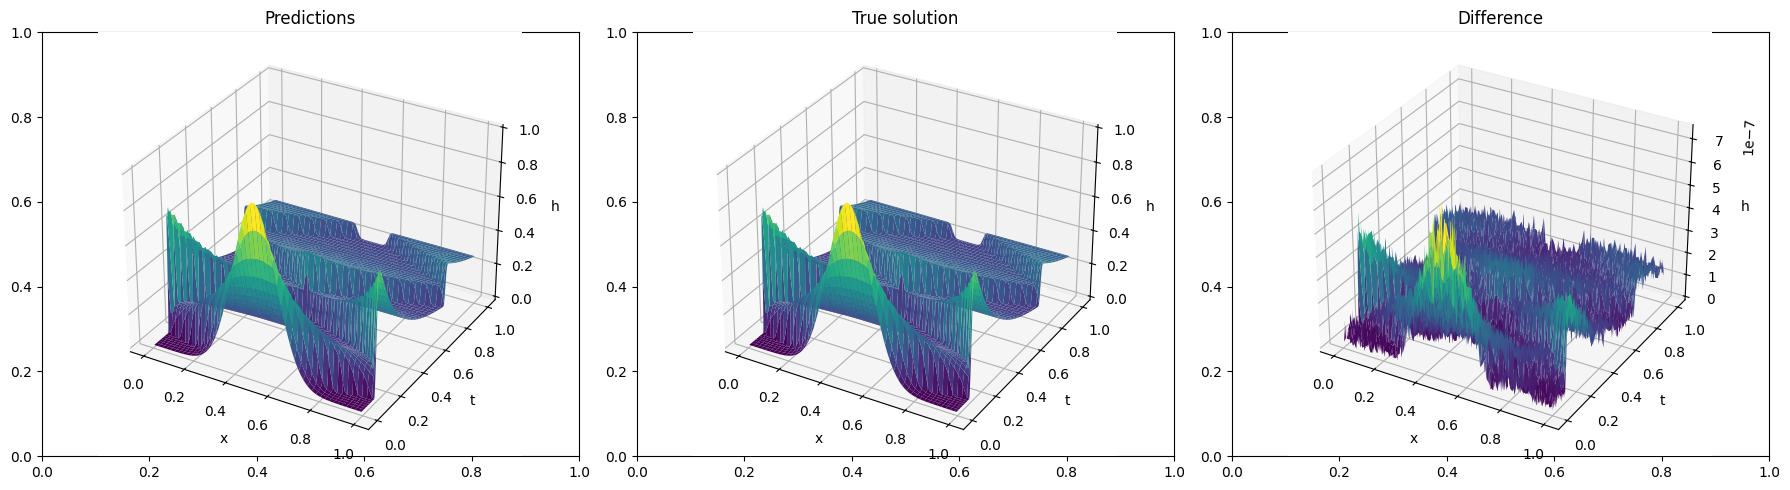

In [49]:
# Make 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot the predicted solution
ax[0] = fig.add_subplot(131, projection='3d')
ax[0].plot_surface(X, T, y_pred, cmap='viridis')
ax[0].set_title('Predictions')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_zlabel('h')

# Plot the true solution
ax[1] = fig.add_subplot(132, projection='3d')
ax[1].plot_surface(X, T, h_all, cmap='viridis')
ax[1].set_title('True solution')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('h')

# Plot the difference
ax[2] = fig.add_subplot(133, projection='3d')
ax[2].plot_surface(X, T, np.abs(y_pred - h_all), cmap='viridis')
ax[2].set_title('Difference')
ax[2].set_xlabel('x')
ax[2].set_ylabel('t')
ax[2].set_zlabel('h')

plt.tight_layout()

if save:
    plt.savefig('plots/FNOpredictions.pdf', format='pdf')

plt.show()


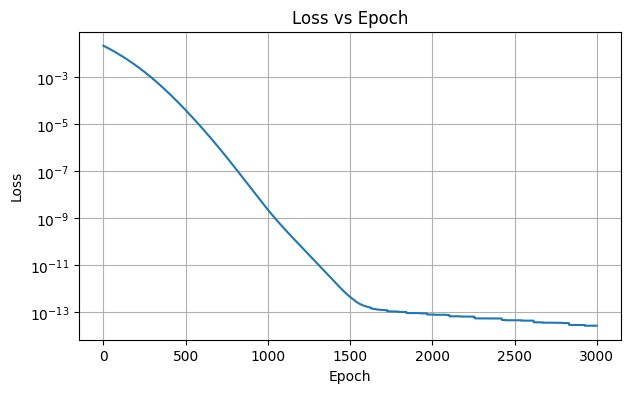

In [50]:
# Plot the loss
plt.figure(figsize=(7, 4))
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.grid()

if save:
    plt.savefig('plots/FNOloss.pdf', format='pdf')

plt.show()


RMSE: 1.6351975747210905e-07


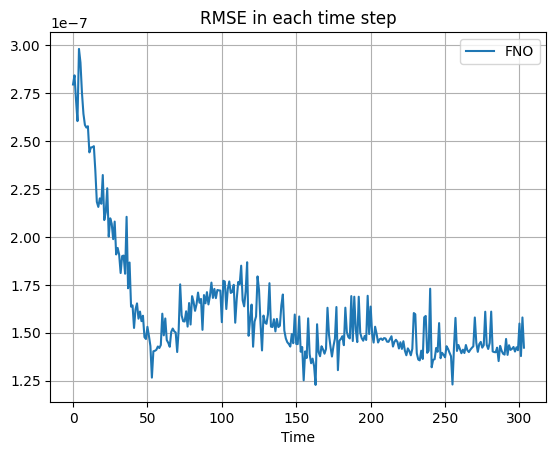

In [51]:
# Calculate RMSE in each time step
rmse_val = rmse(y_pred, h_all)
print(f'RMSE: {rmse_val}')

# Plot error
error_FNO = []

for i in range(h_all.shape[0]):
    error_FNO.append(rmse(y_pred[i], h_all[i]))

plt.plot(error_FNO, label='FNO')
plt.xlabel('Time')
plt.title('RMSE in each time step')
plt.legend()
plt.grid()
plt.show()


### Predictions 

In [52]:
# Define percentage of data to use for training
P = 0.8

# Split the data into training and testing sets
n_train = int(P * len(t))

h_train = h_all[:n_train, :]
h_test = h_all[n_train:, :]

# Split X and T into training and testing sets
X_train = X[:n_train, :]
X_test = X[n_train:, :]
T_train = T[:n_train, :]
T_test = T[n_train:, :]

In [53]:
# Get dimensions
N1, N2 = h_train.shape
print(N1, N2)

N1_test, N2_test = h_test.shape
print(N1_test, N2_test)

# Prepare data
h_train_tensor = torch.tensor(h_train, dtype=torch.float32).unsqueeze(1) # Target tensor
h_train_tensor = h_train_tensor.unsqueeze(-1)
print(h_train_tensor.shape)

h_test_tensor = torch.tensor(h_test, dtype=torch.float32).unsqueeze(1) # Target tensor
h_test_tensor = h_test_tensor.unsqueeze(-1)
print(h_test_tensor.shape)


243 100
61 100
torch.Size([243, 1, 100, 1])
torch.Size([61, 1, 100, 1])


In [54]:
# Define the model
model = SpectralConv2d(2, 1, 100, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criteria = nn.MSELoss()

losses = []

n_epochs = 100
for epoch in range(n_epochs):

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    output = model(h_train_tensor) # Predict
    loss = criteria(output, h_train_tensor) # Calculate loss
    losses.append(loss.item()) # Save loss

    # Backward pass
    loss.backward() # Calculate gradients
    optimizer.step() # Update weights

    # Print loss
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.017523065209388733
Epoch 50, Loss: 0.010979346930980682


In [55]:
# Predictions
y_pred = model(h_train_tensor).detach().numpy().squeeze()
y_pred = y_pred.reshape(N1, N2)



In [56]:
h_train_val = h_train_tensor[-1:]
y_pred_val = model(h_train_val).detach().numpy().squeeze()


In [57]:
predictions = []

